- https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# load data
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape((28, 28))
#plt.imshow(sample_image, cmap='gray')

(1, 784)


In [4]:
# discriminator network
def discriminator(images, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()
    
    # First convolutional and pool layers
    # This finds 32 different 5x5 pixel features
    # conv => relu => avg_pooling
    # 28x28x1 => 14x14x32
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32],
                           initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Second convolutional and pool layers
    # This finds 64 different 5x5 pixel features
    # conv => relu => avg_pooling
    # 14x14x32 => 7x7x64
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64],
                           initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    # FC => relu
    # 7x7x64 => 1024
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024],
                           initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    # 1024 => 1
    d_w4 = tf.get_variable('d_w4', [1024, 1],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1],
                           initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4
    
    # d4 contains unscaled values
    return d4

- d_w1はフィルタの重み 5x5で1チャンネル入力、32チャンネル（特徴マップ）出力の意味
- tensorflowのstridesは[1, stride, stride, 1]と[0]と[3]は必ず1で固定する
- discriminatorにbatch normは入れていない

In [5]:
# generator network
def generator(z, batch_size, z_dim):
    # z_dim:(100, ) => (3136, ) => (56, 56, 1) => bn => relu
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32,
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    # Generate 50 features
    # (56, 56, 1) => (28, 28, 1) => (56, 56, 50) => bn => relu
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim / 2], dtype=tf.float32,
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim / 2],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # Generate 25 features
    # (56, 56, 50) => (28, 28, 25) => (56, 56, 25) => bn => relu
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim / 2, z_dim / 4], dtype=tf.float32,
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim / 4],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    # Final convolution with one output channel
    # (56, 56, 25) => (28, 28, 1)
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim / 4, 1], dtype=np.float32,
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1],
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # g4: (batch_size, 28, 28, 1)
    return g4

- strides=2のconv2dなのでいったんサイズは半分になる
- resize_images()で元のサイズに拡大している？
- 最初から生成したい画像サイズより大きなベクトルを用意している
- Upsamplingは使わない？

In [6]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
generated_image_output = generator(z_placeholder, 1, z_dimensions)

- シンボルを定義している
- 実際に実行するにはfeed_dictで実物のデータを与える
- Variable already existsが出たときはカーネルを再起動する
- 2回同じセルと実行してしまったためにすでに定義済みとでるようだ

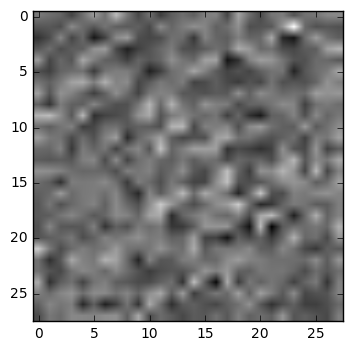

In [7]:
z_batch = np.random.normal(0, 1, [1, z_dimensions])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                               feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape((28, 28))
    plt.imshow(generated_image, cmap='gray')

- z_batchが (1, 100) バッチサイズ数1なので generated_imageは (1, 28, 28, 1) を返す
- まだGeneratorを学習していないので変な画像しか生成されない

In [8]:
tf.reset_default_graph()
batch_size = 50

# z_placeholder is for feeding input noise to the generator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')

# x_placeholder is for feeding input images to the discriminator
x_placeholder = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='x_placeholder')

# Gz holds the generated images
Gz = generator(z_placeholder, batch_size, z_dimensions)

# Dx will hold discriminator prediction probabilities for the real MNIST images
Dx = discriminator(x_placeholder)

# Dg will hold discriminator prediction probabilities for generated images
Dg = discriminator(Gz, reuse=True)

- reuseは何？
- Dxは本物の画像を入力したときのdiscriminatorの出力
- Dgは偽物の画像を入力したときのdiscriminatorの出力

In [9]:
# 本物の画像を入力したときは1を出すのが正解
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))

# 偽物の画像を入力したときは0を出すのが正解
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

In [10]:
# Generatorは偽物の画像を入れたときに1を出すのが正解
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [11]:
tvars = tf.trainable_variables()

In [12]:
tvars

[<tf.Variable 'g_w1:0' shape=(100, 3136) dtype=float32_ref>,
 <tf.Variable 'g_b1:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'bn1/beta:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'g_w2:0' shape=(3, 3, 1, 50) dtype=float32_ref>,
 <tf.Variable 'g_b2:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'bn2/beta:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'g_w3:0' shape=(3, 3, 50, 25) dtype=float32_ref>,
 <tf.Variable 'g_b3:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'bn3/beta:0' shape=(25,) dtype=float32_ref>,
 <tf.Variable 'g_w4:0' shape=(1, 1, 25, 1) dtype=float32_ref>,
 <tf.Variable 'g_b4:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'd_w1:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'd_b1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'd_w2:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'd_b2:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'd_w3:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'd_b3:0' shape=(1024,) dtype=float32_re

In [13]:
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [14]:
with tf.variable_scope(tf.get_variable_scope(), reuse=False): 
    # train the discriminator
    d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
    d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

    # train the generator
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

ValueError: Variable d_w1/Adam/ does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?